In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
# import for model
from keras.models import Model
from keras import regularizers
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.layers import Input, LSTM, Dense, Concatenate, Reshape, Dropout, Bidirectional, Add
from keras.callbacks import EarlyStopping

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.list_physical_devices('GPU')

In [ ]:
os.makedirs(f'./BiLSTM_exps', exist_ok = True)
time_step = 5

#check file exist
t_path = f'./BiLSTM_exps/merged_data/train.csv'
v_path = f'./BiLSTM_exps/merged_data/val.csv'
p_path = f'./BiLSTM_exps/merged_data/pred.csv'

if os.path.exists(t_path) and os.path.exists(v_path) and os.path.exists(p_path): # if already exist, just use them
    train_df = pd.read_csv(t_path)
    val_df = pd.read_csv(v_path)
    pred_df = pd.read_csv(p_path)
else: # else generate from features.csv
    # read every single independent piece segment into sub_dfs
    df = pd.read_csv('./Data./features.csv')
    pieces = [piece for _, piece in df.groupby((df['Note_number'] == 0).cumsum())] # every element in sub_dfs is a independent piece
    new_pieces = []

    # train:val:pred = 8:1:1
    train_ratio = 0.8
    val_ratio = 0.1
    # pred_ratio = 1 - 0.8 - 0.1 = 0.1
    train_idx = math.floor(len(pieces) * train_ratio)
    val_idx = math.floor(len(pieces) * (train_ratio + val_ratio))
    
    for piece in pieces:
        none_val_left = pd.DataFrame({col: [-1] * (time_step - 1) for col in piece.columns})
        piece = pd.concat([none_val_left, piece]).reset_index(drop = True)
        new_pieces.append(piece)
    pieces = new_pieces    

    # shuffle pieces
    random.shuffle(pieces)

    train_df = pd.concat(pieces[:train_idx])
    val_df = pd.concat(pieces[train_idx:val_idx])
    pred_df = pd.concat(pieces[val_idx:]) # without none_val: add "df.iloc[4:] for df in " before pieces[val_idx:]

    # store the shuffled state
    os.makedirs(f'./BiLSTM_exps./merged_data', exist_ok = True)
    train_df.to_csv(t_path, index = False)
    val_df.to_csv(v_path, index = False)
    pred_df.to_csv(p_path, index = False)

In [3]:
def draw(history, path):
    # draw begin loss
    epochs = range(1, len(history['loss'])+1)
    plt.plot(epochs, history['loss'], label = 'Training Begin Loss')
    plt.plot(epochs, history['val_loss'], label = 'Validation Begin Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training/Validation loss of begin fingering')
    plt.legend(loc = 'upper right')
    min_val_loss = min(history['val_loss'])
    min_val_loss_epoch = history['val_loss'].index(min_val_loss)+1
    temp_arr = history['loss'] + history['val_loss']
    plt.annotate(f'Min Validation Loss: {min_val_loss} (Epoch {min_val_loss_epoch})',
                xy = (min_val_loss_epoch, round(min_val_loss, 3)),
                xytext = (len(epochs) * 0.25, (max(temp_arr) + min(temp_arr)) / 2),
                arrowprops = dict(arrowstyle = '->'))
    plt.savefig(f'{path}./training_validation_Begin_loss.png')
    plt.show()
    plt.close()
    # draw begin accuracy
    plt.plot(epochs, history['accuracy'], label = 'Training Begin Accuracy')
    plt.plot(epochs, history['val_accuracy'], label = 'Validation Begin Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training/Validation accuracy of begin fingering')
    plt.legend(loc = 'lower right')
    val_accuracy_at_min_val_loss = history['val_accuracy'][min_val_loss_epoch-1]
    temp_arr = history['accuracy'] + history['val_accuracy']
    plt.annotate(f'Validation Accuracy at epoch {min_val_loss_epoch}: {val_accuracy_at_min_val_loss}',
                xy = (min_val_loss_epoch, round(val_accuracy_at_min_val_loss,3)),
                xytext = (len(epochs) * 0.25, (max(temp_arr) + min(temp_arr)) / 2),
                arrowprops = dict(arrowstyle = '->'))
    plt.savefig(f'{path}./training_validation_Begin_accuracy.png')
    plt.show()
    plt.close()

In [4]:
def draw_confusion_matrix(y_true, y_pred, path, labels):
    # create confusion matrix
    all_labels = range(10) # 5 fingerings in total
    matrix = confusion_matrix(y_true, y_pred, labels = all_labels)
    # plot confusion matrix
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = 'g', xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - merged hands')
    plt.savefig(path)
    plt.show()
    plt.close()

In [5]:
# design input for time step
def df_to_X_y(df, window_size = 5, features = 8):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df) - window_size + 1):
        # distribute data
        row = [[a] for a in df_as_np[i:i+window_size,:features]] # df[['Note_number', 'Onset_time_in_sec', 'Offset_time_in_sec', 'Pitch', 'KeyPos_x', 'KeyPos_y', 'Onset_velocity', 'Offset_velocity']].to_numpy()
        X.append(row) # input features for 20 data
        label = df_as_np[i+window_size-1, features] # df[['Begin_fingering', 'End_fingering']].to_numpy()
        label = int(label)
        if label < 0:
            y.append(4 - (abs(label)-1))
        else:
            y.append(label+4)
        
    return tf.convert_to_tensor(X), tf.convert_to_tensor(y)

In [6]:
# discard useless columns
train_df = train_df.drop(['Duration', 'Begin_hand', 'Has_fingering_substitution', 'End_hand', 'End_fingering'], axis = 1)
val_df = val_df.drop(['Duration', 'Begin_hand', 'Has_fingering_substitution', 'End_hand', 'End_fingering'], axis = 1)
pred_df = pred_df.drop(['Duration', 'Begin_hand', 'Has_fingering_substitution', 'End_hand', 'End_fingering'], axis = 1)
train_df.head()

,Note_number,Onset_time_in_sec,Offset_time_in_sec,Pitch,KeyPos_x,KeyPos_y,Onset_velocity,Offset_velocity,Begin_fingering
0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,0.0,0.217392,75.0,8.0,1.0,65.0,80.0,2.0


In [7]:
# design input, use n data to predict the nth data
train_x, train_BeginY = df_to_X_y(train_df, time_step)
val_x, val_BeginY = df_to_X_y(val_df, time_step)
actual_fingerings = pred_df[['Begin_fingering']]
pred_x, pred_BeginY = df_to_X_y(pred_df, time_step)

# reshape (one-hot)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[3]))
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], val_x.shape[3]))
pred_x = np.reshape(pred_x, (pred_x.shape[0], pred_x.shape[1], pred_x.shape[3]))
train_BeginY = to_categorical(train_BeginY)
val_BeginY = to_categorical(val_BeginY)
pred_BeginY = to_categorical(pred_BeginY)

In [8]:
# prepare to-predict data
## preprocessing
fingerings_mapping = {-1.0: 4, -2.0: 3, -3.0: 2, -4.0: 1, -5.0: 0,
                      1.0: 5, 2.0: 6, 3.0: 7, 4.0: 8, 5.0: 9}

actual_fingerings_one_hot = pred_BeginY

Epoch 1/50
314/314 [==============================] - 18s 27ms/step - loss: 1.7406 - accuracy: 0.3017 - val_loss: 1.5322 - val_accuracy: 0.3675
Epoch 2/50
314/314 [==============================] - 4s 13ms/step - loss: 1.4405 - accuracy: 0.4060 - val_loss: 1.4767 - val_accuracy: 0.4024
Epoch 3/50
314/314 [==============================] - 4s 12ms/step - loss: 1.3638 - accuracy: 0.4386 - val_loss: 1.3508 - val_accuracy: 0.4458
Epoch 4/50
314/314 [==============================] - 4s 13ms/step - loss: 1.3143 - accuracy: 0.4586 - val_loss: 1.3278 - val_accuracy: 0.4512
Epoch 5/50
314/314 [==============================] - 4s 13ms/step - loss: 1.2724 - accuracy: 0.4766 - val_loss: 1.3066 - val_accuracy: 0.4697
Epoch 6/50
314/314 [==============================] - 4s 13ms/step - loss: 1.2336 - accuracy: 0.4941 - val_loss: 1.2934 - val_accuracy: 0.4718
Epoch 7/50
314/314 [==============================] - 4s 13ms/step - loss: 1.1929 - accuracy: 0.5114 - val_loss: 1.2863 - val_accuracy: 0.487

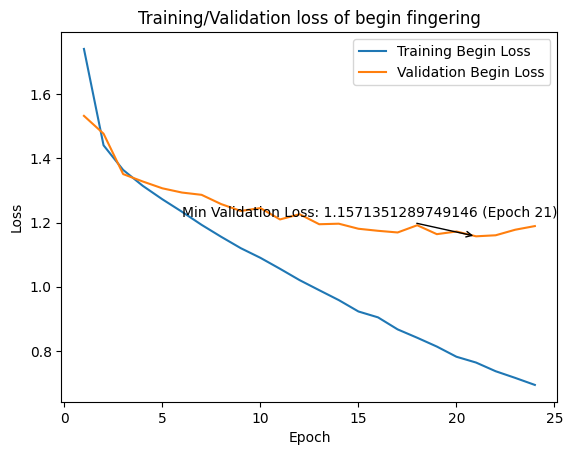

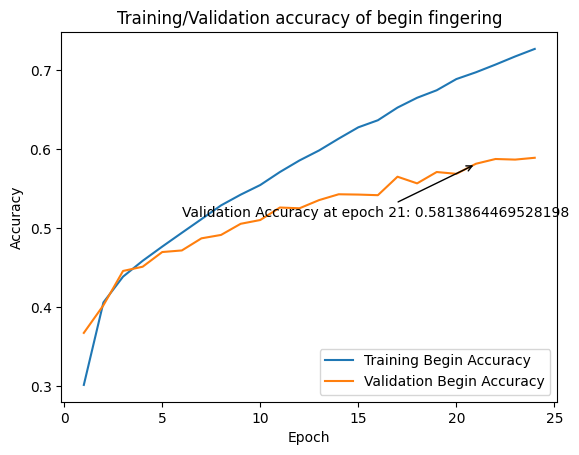

330/330 [==============================] - 3s 4ms/step


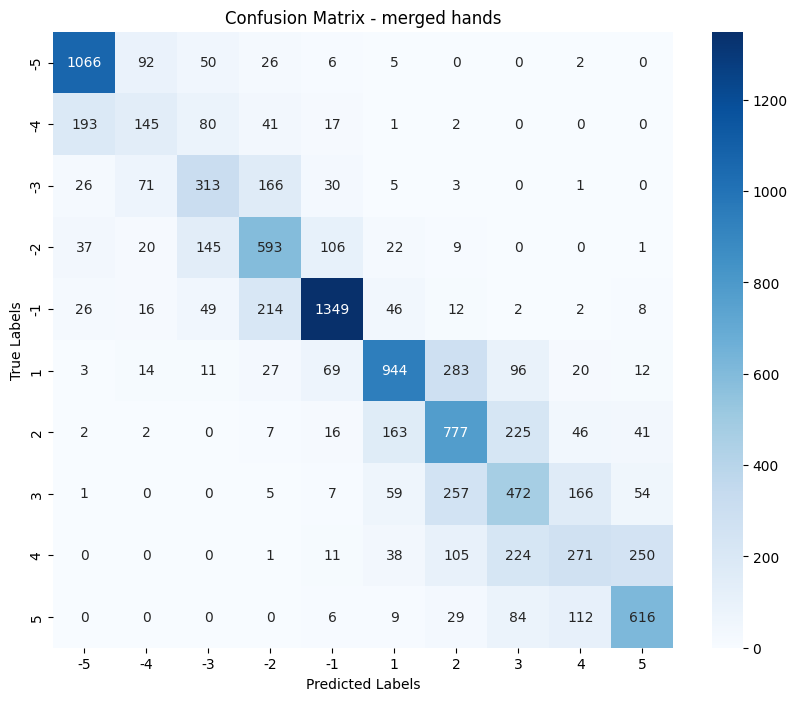

In [9]:
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Input, Flatten, Dropout, Add, Attention, AdditiveAttention
from keras.layers import MultiHeadAttention
from keras.models import Model
from keras.optimizers import Adam

os.makedirs(f'./merged_models', exist_ok = True)
serial_num = 21
#while serial_num != 4:
os.makedirs(f'./merged_models/exp{serial_num}', exist_ok = True)
exp_record = {'exp_num': serial_num}
cur_path = f'./merged_models./exp{serial_num}'

neurons = 256
input_shape = (time_step, 8)
input = Input(shape=input_shape)
x = input

x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
x = MultiHeadAttention(num_heads=8, key_dim=32)(query=x, value=x, key=x)
x = Bidirectional(LSTM(units=10))(x)

# 全連接層作為輸出層
output_layer = Dense(10, activation='softmax', name='output')(x)

# 定義模型
model = Model(inputs=input, outputs=output_layer)

plot_model(model, to_file = f'{cur_path}./structure.png', show_shapes = True, show_layer_names = True)
optimizer1 = Adam()  # 使用梯度裁剪
model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizer1,
                metrics = 'accuracy')

## save settings
with open(f'{cur_path}./settings.txt', 'w') as settings:
    model.summary(print_fn = lambda x: settings.write(x + '\n'))

# train
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
batch = 256
history = model.fit(x = train_x,
                    y = train_BeginY,
                    validation_data = (val_x, val_BeginY),
                    epochs = 50,
                    batch_size = batch,
                    verbose = 1
                    ,callbacks = [early_stopping])

# save final model
model.save(f'{cur_path}./model.h5')
# plot model
draw(history.history, cur_path)
# record
exp_record['val_loss'] = min(history.history['val_loss'])

# predict
pred_probs_Begin = model.predict(pred_x)
output_Begin_fingerings = np.array([[-5.0, -4.0, -3.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0][np.argmax(row)] for row in pred_probs_Begin])

## write predicted probabilities
predicted_path = f'./models./exp{serial_num}./predicted'
os.makedirs(predicted_path, exist_ok = True)
pred_prob_Begin_df = pd.DataFrame(pred_probs_Begin, columns = ['L-1', 'L-2', 'L-3', 'L-4', 'L-5', 'R-1', 'R-2', 'R-3', 'R-4', 'R-5'])
pred_prob_Begin_df.to_csv(f'{predicted_path}./Begin_pred_probs.csv', index = False)
## transform into fingerings and output
output_Begin_fingerings = np.array([[-5.0, -4.0, -3.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0][np.argmax(row)] for row in pred_probs_Begin])
output_df = pd.DataFrame({'Begin_fingering': output_Begin_fingerings})
output_df.to_csv(f'{predicted_path}./pred.csv', index = False)

# evaluate predicteds
temp_actual_fingerings = actual_fingerings[4:]
## map fingerings
y_true_mapped = temp_actual_fingerings['Begin_fingering'].map(fingerings_mapping)
y_pred_mapped = output_df['Begin_fingering'].map(fingerings_mapping)
## confusion matrix
draw_confusion_matrix(y_true_mapped, y_pred_mapped, f'{predicted_path}./matrix.png', [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
## calculate accuracy
output_df.reset_index(drop=True, inplace=True)
temp_actual_fingerings.reset_index(drop=True, inplace=True)

accuracy = np.mean(output_df['Begin_fingering'] == temp_actual_fingerings['Begin_fingering'])
## calculate loss
loss = tf.keras.losses.categorical_crossentropy(actual_fingerings_one_hot, pred_probs_Begin).numpy().mean()
## precision score
precision = precision_score(y_true_mapped, y_pred_mapped, average = 'macro', zero_division = 0)
## recall score
recall = recall_score(y_true_mapped, y_pred_mapped, average = 'macro', zero_division = 0)
## F1 score
f1 = f1_score(y_true_mapped, y_pred_mapped, average = 'macro', zero_division = 0)
## record
with open(f'{predicted_path}./predict_evaluates.txt', 'w') as rr: # results-record
    rr.write(f'accuracy: {accuracy}\n')
    rr.write(f'loss: {loss}\n')
    rr.write(f'Precision score: {precision}\n')
    rr.write(f'Recall score: {recall}\n')
    rr.write(f'F1 score: {f1}\n') 